## Задача 3. Python

**Продолжение `Задания 1`**

Требуется следующее:  
- `Первое`. Необходимо реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  


- `Второе`. Необходимо реализвать функцию, которая будет строить графики по получаемым метрикам.

In [1]:
# Загружаем необходимые библиотеки и модули

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind

import requests
from urllib.parse import urlencode

In [2]:
# Создаем ссылки для прямой загрузки датасетов с яндекс диска

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

url_1 = base_url + urlencode(dict(public_key=groups))
url_3 = base_url + urlencode(dict(public_key=active_studs))
url_4 = base_url + urlencode(dict(public_key=checks))

response_1 = requests.get(url_1)
response_3 = requests.get(url_3)
response_4 = requests.get(url_4)

groups_dataset = response_1.json()['href']
active_studs_dataset = response_3.json()['href']
checks_dataset = response_4.json()['href']

# groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
# url_2 = base_url + urlencode(dict(public_key=groups_add))
# response_2 = requests.get(url_2)
# groups_add_dataset = response_2.json()['href']

### Первый пункт
**Формирование функции для вывода метрик**  
В функции реализован полный цикл от загрузки датасетов и формирования таблиц до выгрузки итоговых показателей метрик:
- Загрузка трех основных датасетов и присвоение одинаковых имен колонок  
- Загрузка четвертого датасета с дополнительными пользователями реализована с помощью конструкции "try - except" для обработки исключений. Если датасет по ссылке отсутствует, то будет предупреждение об этом  
- Формирование таблиц  
- Расчет метрик CR и ARPPU

In [3]:
def build():
    df_groups = pd.read_csv(groups_dataset, sep=';', header=0, names=['user_id', 'group'])
    df_active_user = pd.read_csv(active_studs_dataset, header=0, names=['user_id'])
    df_checks = pd.read_csv(checks_dataset, sep=';', header=0, names=['user_id', 'pay'])

    try:
        df_add = pd.read_csv(groups_add_dataset, header=0, names=['user_id', 'group'])
        df_groups = df_groups.append(df_add)
        print('Результаты с учетом дополнительных пользователей')
    except NameError:
        print('ВНИМАНИЕ! Дополнительные пользователи не загружены')
    
    df_1 = df_active_user.merge(df_groups, how='left')
    df_1 = df_1.dropna()
    
    df_2 = df_checks.merge(df_groups, how='left')
    df_2 = df_2.dropna()
    
    total_df = df_1.merge(df_2, how='outer')
    total_df.fillna(value=0, inplace=True)
    total_df['pay_mark'] = total_df.pay.apply(lambda x: 'no' if x == 0 else 'yes')

    table = total_df.groupby(['group', 'pay_mark']) \
                    .agg({'pay_mark': 'count'}) \
                    .rename(columns={'pay_mark': 'count'}) \
                    .reset_index()
    
    table = table.pivot(index='group', columns='pay_mark', values='count')

    CR_to_payment = ((table.yes / (table.no + table.yes)) * 100).round(2)
    
    stat, p_CR, dof, expected = chi2_contingency(table)

    ARPPU = total_df.query('pay > 0').groupby('group').pay.mean().round(2)
    
    p_ARPPU = ttest_ind(total_df.query('group == "A" & pay > 0').pay,
                        total_df.query('group == "B" & pay > 0').pay)
    
    return CR_to_payment, p_CR, ARPPU, p_ARPPU[1]

**Применяем функцию**

In [4]:
CR, p_CR, ARPPU, p_ARPPU = build()

print(f"\nМетрика CR:\n{CR}\n\n p-value CR: {p_CR}\n\nМетрика ARPPU:\n{ARPPU}\n\n p-value ARPPU: {p_ARPPU}")

ВНИМАНИЕ! Дополнительные пользователи не загружены

Метрика CR:
group
A    6.84
B    6.26
dtype: float64

 p-value CR: 0.4308630604023529

Метрика ARPPU:
group
A     860.71
B    1107.00
Name: pay, dtype: float64

 p-value ARPPU: 0.002699993302662584


**Обновление данных**  
Допустим теперь нам предоставили ссылку на дополнительных пользователей.  
Назначаем переменную для обновленной информации о дополнительных пользователях.

In [5]:
groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
url_2 = base_url + urlencode(dict(public_key=groups_add))
response_2 = requests.get(url_2)
groups_add_dataset = response_2.json()['href']

**Применяем функцию с учетом доступности дополнительных данных**

In [6]:
CR_n, p_CR_n, ARPPU_n, p_ARPPU_n = build()

print(f"\nМетрика CR:\n{CR_n}\n\n p-value CR: {p_CR_n}\n\nМетрика ARPPU:\n{ARPPU_n}\n\n p-value ARPPU: {p_ARPPU_n}")

Результаты с учетом дополнительных пользователей

Метрика CR:
group
A    6.83
B    6.27
dtype: float64

 p-value CR: 0.4464432666411111

Метрика ARPPU:
group
A     860.71
B    1108.82
Name: pay, dtype: float64

 p-value ARPPU: 0.0025070167572044644


### Второй пункт
**Формирование функции для вывода графиков по получаемым метрикам**  
- Сформирована функцию которая принимает два значения - две метрики "CR" и "ARPPU", полученные из предыдущей функции.  
- На выходе получаем два графика на одной строке (одной горизонтальной оси).  
- Так как метрики по большей части категориальные, то реализованы с помощью диаграммы – барплот

In [7]:
def plot(CR, ARPPU):
    figure, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax_1 = sns.barplot(data=CR.reset_index(), x='group', y=0, ax=ax[0])
    ax_1.set_xlabel('Экспериментальная группа', fontsize=15)
    ax_1.set_ylabel('')
    ax_1.set_ylim(0, 10)
    ax_1.set_title('Метрика CR (%)', fontsize=20)
    
    ax_2 = sns.barplot(data=ARPPU.reset_index(), x='group', y='pay', ax=ax[1])
    ax_2.set_xlabel('Экспериментальная группа', fontsize=15)
    ax_2.set_ylabel('')
    ax_2.set_title('Метрика ARPPU (у.е.)', fontsize=20)

**Применяем функцию с метриками без дополнительных данных**

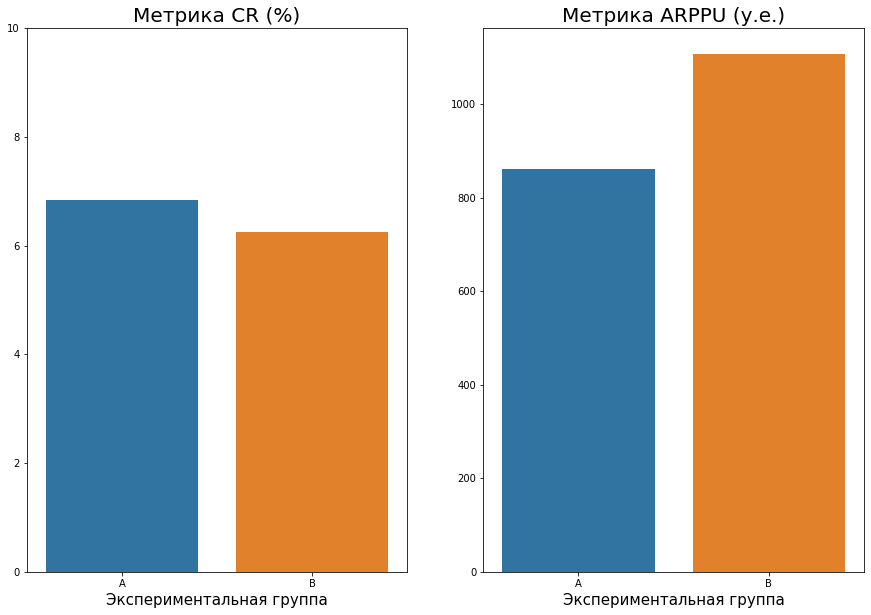

In [8]:
plot(CR, ARPPU)

**Применяем функцию с метриками после загрузки дополнительных данных**

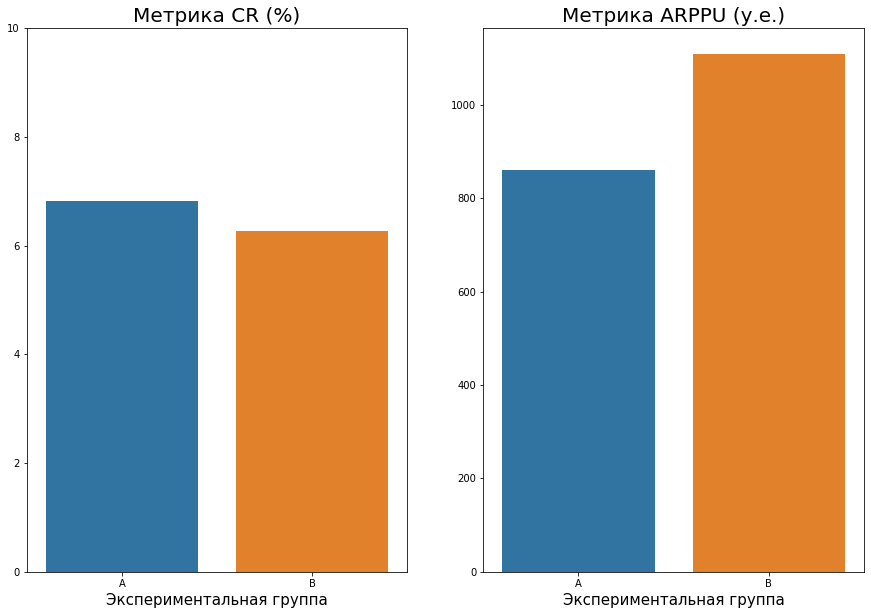

In [9]:
plot(CR_n, ARPPU_n)